In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from PIL import Image
import os, os.path
from autocrop import Cropper
from sklearn import svm

# Eigenfaces and their application in Covid-19 detection
## Margarita Savova

### Abstract

In this project I am checking if the eigenfaces approach generalizes to other types of data, in this case X-ray images of patients with pneumonia of different types.

### Mathematical concepts
### Eigenvalues and eigenvectors

When applying a linear transformation, almost all vectors change their direction. Those special non-zero vectors which remain on their span after applying the transformation, are called eigenvectors. 
Each eigenvector has associated with it what is called an eigenvalue, which is the factor by which the eigenvector is stretched or shrunk or reversed or left unchanged during the transformation.

This can be represented with the following equation: $$ A \textbf{x} = \lambda \textbf{x} \tag{1} $$ 

where A is the square transformation matrix, $ \textbf{x} $ is an eigenvector and $ \lambda $ is its corresponding eigenvalue.
This means that the matrix-vector product gives the same result as scaling the same eigenvector by a value $ \lambda $.

### Eigenbasis and spectrum of a matrix

If A has $ \textit n $ linearly independent eigenvectors, then those would be a basis for $ \mathbb{R}^n $. 
When such basis B = {$ \textbf{x}_1, \textbf{x}_2, \dots, \textbf{x}_n $} called $ \textit eigenbasis $ is being used, the transformation matrix with respect to this eigenbasis, is a diagonal matrix, which is easier to work with: 

$$ D = \begin{bmatrix} \lambda_1& 0 & \dots & 0 \\0 & \lambda_2 & \dots & 0\\ \vdots&\vdots&\ddots&\vdots\\ 0 & 0 & \dots & \lambda_n \end{bmatrix} $$

The determinant of the matrix equals the product of its eigenvalues. The $ \textit{spectrum of a matrix}$ is the set of its eigenvalues. If $ T\colon V \rightarrow V $ is a linear operator over any finite-dimensional vector space, its spectrum is the set of scalars $ \lambda $ such that $ T - \lambda I $ is not invertible.

### Computation of eigenvalues and eigenvectors of a matrix

From the above equation (1), which is also called $ \textit{the eigenvalue equation} $, we can derive $ \textit{the characteristic equation} $: 

$$ \det{(A - \lambda I) = 0} \tag{2} $$ 

where the number $ \lambda $ is an eigenvalue of A if and only if $ A - \lambda I $ is singular. The vector $ \textbf{x} $ is in the nullspace of $ A - \lambda I $. The number $ \lambda $ is chosen so that $ A - \lambda I $ has a nullspace [1].

It can be shown that if A is an n × n matrix, then $ \det{(A − \lambda I)} $ is a polynomial in the variable λ of degree n. We call this polynomial the characteristic polynomial of A.

$ \textbf{Example:} $ Consider the matrix $ A = \begin{bmatrix} 3&-4&2 \\ 0&6&-5 \\ 0&0&4 \end{bmatrix} $. To find the eigenvalues of A, we must compute $ \det{(A − \lambda I)} $, set this expression equal to 0 and solve for $ \lambda $. Note that 

$$ A - \lambda I = \begin{bmatrix} 3&-4&2 \\ 0&6&-5 \\ 0&0&4 \end{bmatrix} - \begin{bmatrix} \lambda&0&0 \\ 0&\lambda&0 \\ 0&0&\lambda \end{bmatrix} = \begin{bmatrix} 3-\lambda&-4&2 \\0&6-\lambda&-5 \\ 0&0&4-\lambda \end{bmatrix} $$ 

or $ (3 - \lambda)(6 - \lambda)(4 - \lambda) = 0 $. Solving for $ \lambda $, we get that $ \lambda $ = 3, 4, or 6. These are the three eigenvalues of A.

Now we can find the eigenvectors {$ x_i $}, i = 1, 2, 3 by solving the following equation: 

$$ (A - \lambda_i I)(x_i) = (0) \tag{3}$$ 

The solution is a linear independent set of vectors, such that: $ x_1 = \begin{bmatrix} 3 \\ 0 \\ 0 \end{bmatrix}; x_2 = \begin{bmatrix} 2 \\ -5 \\ 0 \end{bmatrix}; x_3 = \begin{bmatrix} -2 \\ 3 \\ 0 \end{bmatrix} $

### Projection

The projection of a vector is the dot product of a matrix with the vector itself, resulting in a new vector that has one of the dimentions of the matrix.

### PCA

Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the data into fewer dimensions, which act as summaries of features [2].

### Principal components

PCA reduces data by geometrically projecting them onto lower dimensions called principal components (PCs), with the goal of finding the best summary of the data using a limited number of PCs. The first PC is chosen to minimize the total distance between the data and their projection onto the PC. By minimizing this distance, we also maximize the variance of the projected points, $ \sigma^2 $. The second (and subsequent) PCs are selected similarly, with the additional requirement that they be uncorrelated with all previous PCs. For example, projection onto PC1 is uncorrelated with projection onto PC2, and we can think of the PCs as geometrically orthogonal. The number of PCs corresponds to the number of dimensions we have. 

### Singular Value Decomposition

SVD is a variation of PCA, which generalizes for most use cases. In this notebook I am using SVD for extracting eigenfaces.


## Eigenfaces

### Eigenfaces approach on faces

I am using the Yale Face Database containing 165 grayscale images in GIF format of 15 individuals. There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.

In [3]:
imgs = []
path = "data/yalefaces"

In [4]:
for f in os.listdir(path):
    imgs.append(mpimg.imread(os.path.join(path,f)))

In [5]:
#number of images
len(imgs)

165

In [6]:
imgs[0]

array([[130, 130, 130, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

In [7]:
#number of pixels in an image
imgs[0].shape

(243, 320)

In [8]:
cropper = Cropper()
num_images = 165
cropped_imgs = np.empty((num_images, 500, 500))
for i in range(len(imgs)):
    cropped_array = cropper.crop(imgs[i])
    cropped_imgs[i] = cropped_array
    
cropped_imgs.shape

(165, 500, 500)

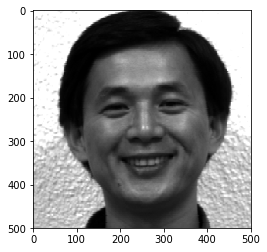

In [9]:
plt.imshow(cropped_imgs[57], cmap = "gray")

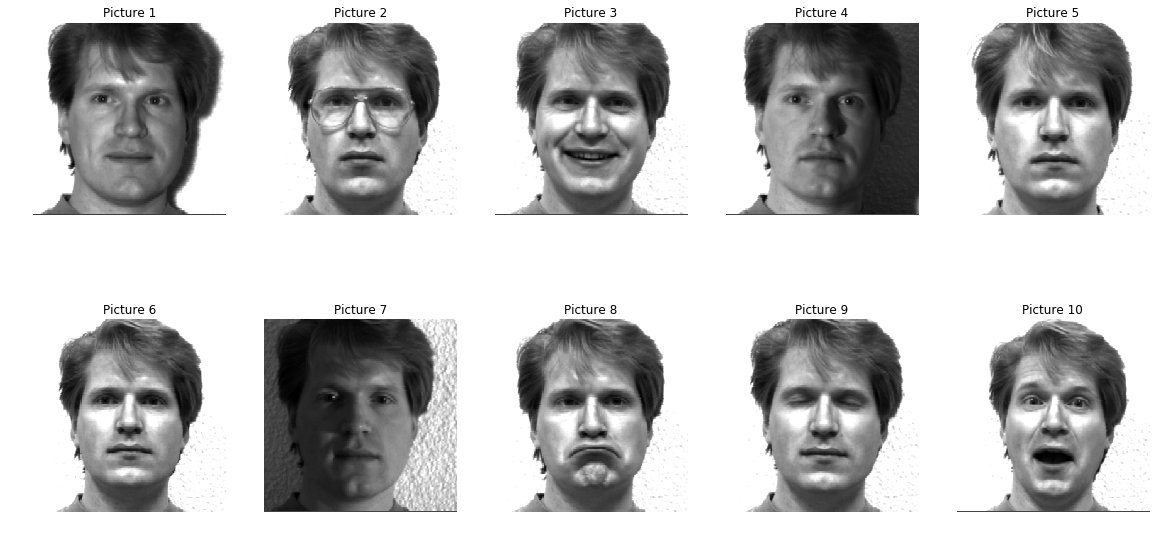

In [10]:
fig = plt.figure(figsize = (20, 10))
for j in range(10):
    a = fig.add_subplot(2, 5, j+1)
    imgplot = plt.imshow(cropped_imgs[j], cmap = "gray")
    a.set_title(f'Picture {j+1}')
    plt.axis("off")

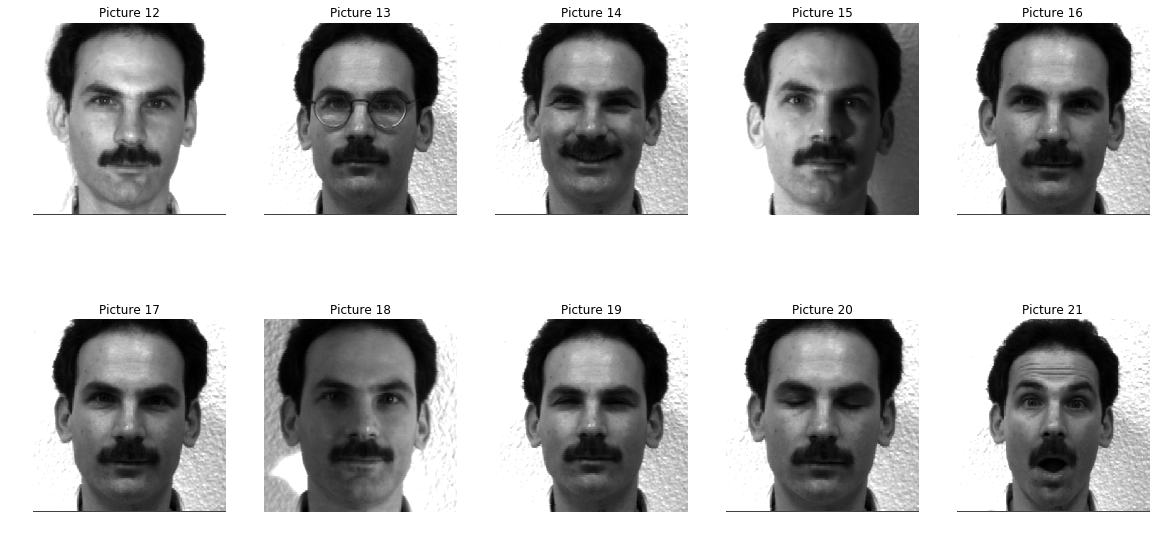

In [11]:
fig1 = plt.figure(figsize = (20, 10))
for j in range(10):
    a = fig1.add_subplot(2, 5, j+1)
    imgplot = plt.imshow(cropped_imgs[11+j], cmap = "gray")
    a.set_title(f'Picture {11+j+1}')
    plt.axis("off")

In [12]:
len(cropped_imgs)

165

We create a matrix of the images, but remove the last 22 images, corresponding to 2 people for testing purposes.

In [13]:
image_matrix = np.array([cropped_imgs[i].flatten() for i in range(len(cropped_imgs))])[:-22].T
image_matrix.shape

(250000, 143)

In [14]:
avg_face = np.mean(image_matrix, axis=1)

In [15]:
avg_face.shape

(250000,)

Taking the mean of all pictures, we can get an average face, which we are going to subtract from the data.

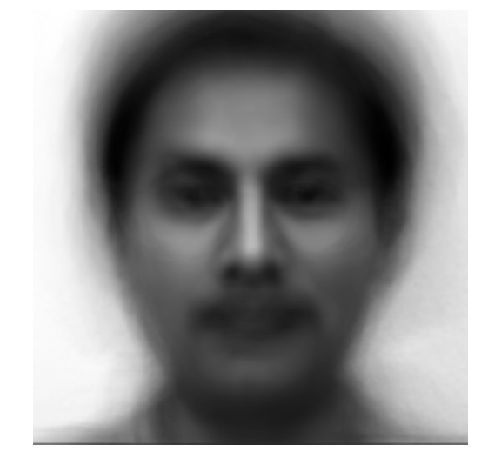

In [16]:
fig_avg_face = plt.figure(figsize=(8, 8))
plt.imshow(avg_face.reshape(500, 500), cmap = "gray")
plt.axis("off")
plt.show()

In [17]:
#subtracting mean face from the data
X = image_matrix - np.tile(avg_face, (image_matrix.shape[1], 1)).T
X.shape

(250000, 143)

In [40]:
#computing the U, S and VT matrices after Singular Value Decomposition
U, S, VT = np.linalg.svd(X, full_matrices=0)

In [41]:
U.shape, S.shape, VT.shape

((250000, 143), (143,), (143, 143))

In [42]:
np.amin(U[:, 0])

-0.0013503039002254176

In [37]:
# U[:, 0] = (U[:, 0]).astype(int)

In [43]:
# U[:, 0].reshape(500, 500)

In [45]:
U[:, 0].reshape(500, 500)

array([[0.0003673 , 0.0003673 , 0.00037405, ..., 0.00105156, 0.00102709,
        0.00102709],
       [0.0003673 , 0.0003673 , 0.00037405, ..., 0.00105156, 0.00102709,
        0.00102709],
       [0.00043088, 0.00043088, 0.00043411, ..., 0.00105775, 0.00103855,
        0.00103855],
       ...,
       [0.0022077 , 0.0022077 , 0.00217438, ..., 0.00178471, 0.00171489,
        0.00171489],
       [0.00156199, 0.00156199, 0.00155512, ..., 0.00124981, 0.00121508,
        0.00121508],
       [0.00156199, 0.00156199, 0.00155512, ..., 0.00124981, 0.00121508,
        0.00121508]])

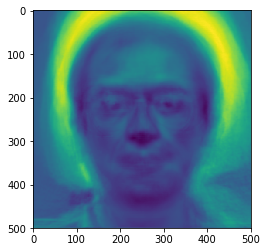

In [44]:
plt.imshow(U[:, 0].reshape(500, 500))

The column vectors of U have the same shape as the column vectors of X, so they can be reshaped into eigenfaces.

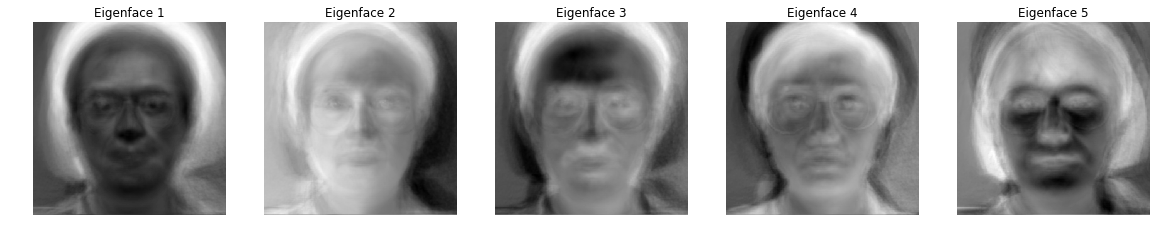

In [20]:
fig2 = plt.figure(figsize = (20, 10))
for j in range(5):
    a = fig2.add_subplot(1, 5, j+1)
    imgplot = plt.imshow(U[:, j].reshape(500, 500), cmap = "gray")
    a.set_title(f'Eigenface {j+1}')
    plt.axis("off")

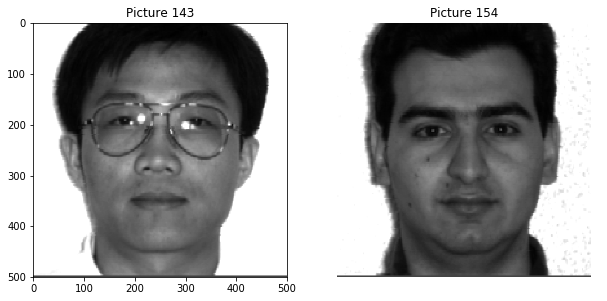

In [21]:
#first pictures of the 2 people not used in the extraction of eigenfaces
fig_test = plt.figure(figsize = (10, 10))
test_img_1 = fig_test.add_subplot(1, 2, 1)
plt.imshow(cropped_imgs[143], cmap = "gray")
test_img_1.set_title(f'Picture 143')
test_img_2 = fig_test.add_subplot(1, 2, 2)
plt.imshow(cropped_imgs[154], cmap = "gray")
test_img_2.set_title(f'Picture 154')
plt.axis("off")
plt.show()

In [22]:
test_face_1 = cropped_imgs[143].flatten() - avg_face
test_face_2 = cropped_imgs[154].flatten() - avg_face
test_face_1.shape, test_face_2.shape

((250000,), (250000,))

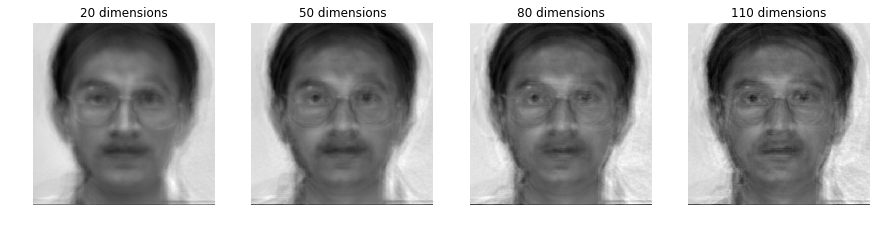

In [106]:
r_list = [20, 50, 80, 110]

fig_test_reconstructed_1 = plt.figure(figsize=(15, 15))
for i in range(len(r_list)):
    img = fig_test_reconstructed_1.add_subplot(1, 4, i+1)
    num_components = r_list[i]
    reconstructed_face = avg_face + U[:, :num_components] @ (U[:, :num_components].T @ test_face_1)
    plt.imshow(np.reshape(reconstructed_face, (500, 500)), cmap="gray")
    img.set_title(f"{r_list[i]} dimensions")
    plt.axis("off")

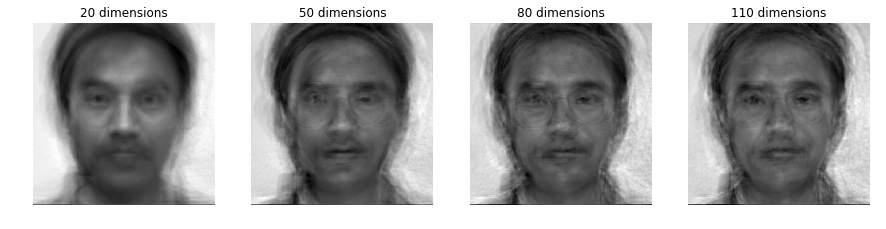

In [107]:
fig_test_reconstructed_2 = plt.figure(figsize=(15, 15))
for i in range(len(r_list)):
    img = fig_test_reconstructed_2.add_subplot(1, 4, i+1)
    num_components = r_list[i]
    reconstructed_face = avg_face + U[:, :num_components] @ (U[:, :num_components].T @ test_face_2)
    plt.imshow(np.reshape(reconstructed_face, (500, 500)), cmap="gray")
    img.set_title(f"{r_list[i]} dimensions")
    plt.axis("off")

We can see that the newly constructed faces are far from the original ones, but this should improve once we have a bigger dataset to start with.

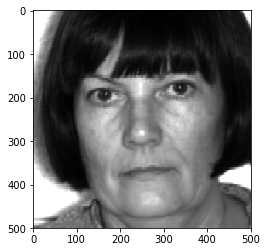

In [25]:
plt.imshow(cropped_imgs[110], cmap="gray")

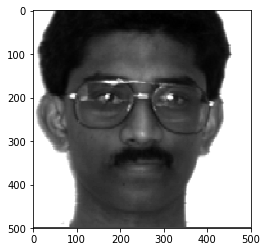

In [26]:
plt.imshow(cropped_imgs[132], cmap="gray")

In [27]:
person_1 = np.array([cropped_imgs[i].flatten() for i in range(110, 121)]).T
person_2 = np.array([cropped_imgs[i].flatten() for i in range(132, 143)]).T

person_1.shape, person_2.shape

((250000, 11), (250000, 11))

In [28]:
person_1 = person_1 - np.tile(avg_face, (person_1.shape[1], 1)).T
person_2 = person_2 - np.tile(avg_face, (person_2.shape[1], 1)).T

person_1.shape, person_2.shape

((250000, 11), (250000, 11))

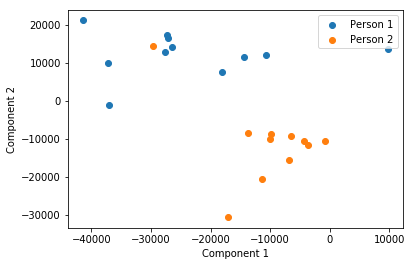

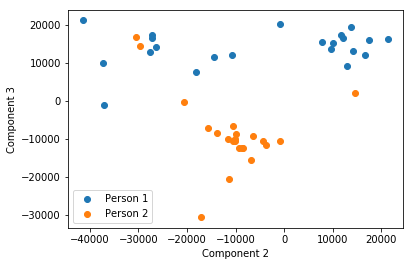

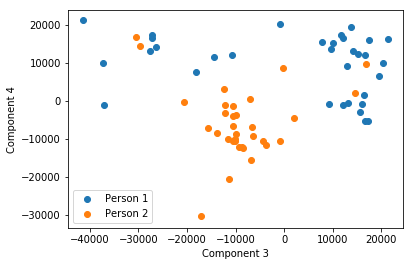

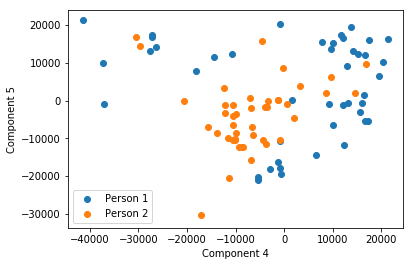

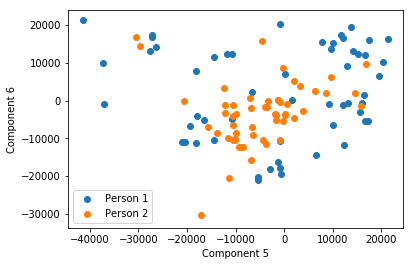

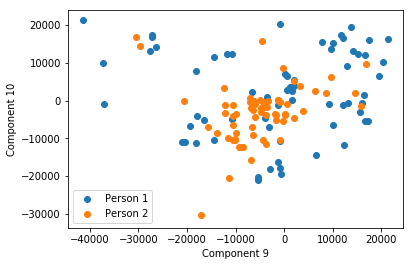

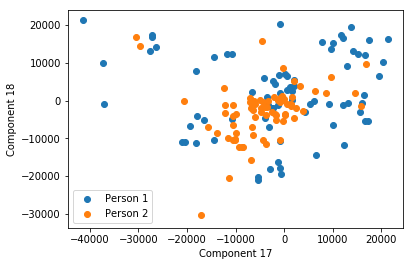

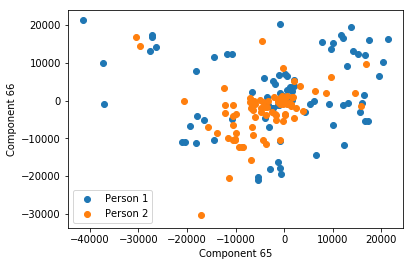

In [61]:
component_1_test = [0, 1, 2, 3, 4, 8, 16, 64]
component_2_test = [1, 2, 3, 4, 5, 9, 17, 65]

x_person_1 = []
y_person_1 = []
x_person_2 = []
y_person_2 = []

for k in range(len(component_1_test)):
    for i in range(len(person_1[1])):
        weights_p1 = U[:, component_1_test[k]:component_2_test[k]+1].T @ person_1[:, i]
        x_person_1.append(weights_p1[0])
        y_person_1.append(weights_p1[1])
        weights_p2 = U[:, component_1_test[k]:component_2_test[k]+1].T @ person_2[:, i]
        x_person_2.append(weights_p2[0])
        y_person_2.append(weights_p2[1])
    plt.scatter(x_person_1, y_person_1, label='Person 1')
    plt.scatter(x_person_2, y_person_2, label='Person 2')
    plt.legend()
    plt.xlabel(f'Component {component_1_test[k]+1}')
    plt.ylabel(f'Component {component_2_test[k]+1}')

    plt.show()

Each dot in the scatterplots above represents an image. The coordinates are 2 of the eigenvectors, so we are projecting the images onto those two components. I have tried projecting the data onto different pairs of components. We can see that the data clusters better with the first components and gets mixed up when projected on less important components. We can see how clearly the images of person 1 and person 2 are separated. Thus, we can use this method for clustering images and classifying a new image of the same person. 

### Eigenfaces approach for classifying x-ray images

In [34]:
imgs_covid = np.empty((60, 300, 400))
path_covid = "data/565888_1027538_bundle_archive/NonAugmentedTrain/COVID-19"
imgs_bacterial = np.empty((650, 300, 400))
path_bacterial = "data/565888_1027538_bundle_archive/NonAugmentedTrain/BacterialPneumonia"
imgs_viral = np.empty((412, 300, 400))
path_viral = "data/565888_1027538_bundle_archive/NonAugmentedTrain/ViralPneumonia"

In [35]:
for i in range(len(os.listdir(path_covid))):
    imgs_covid[i] = mpimg.imread(os.path.join(path_covid, os.listdir(path_covid)[i]))

In [36]:
imgs_covid.shape

(60, 300, 400)

In [37]:
train_imgs_covid, test_imgs_covid = imgs_covid[:54], imgs_covid[54:]

In [38]:
train_imgs_covid.shape, test_imgs_covid.shape

((54, 300, 400), (6, 300, 400))

In [39]:
for i in range(len(os.listdir(path_bacterial))):
    imgs_bacterial[i] = mpimg.imread(os.path.join(path_bacterial, os.listdir(path_bacterial)[i]))

In [40]:
imgs_bacterial.shape

(650, 300, 400)

In [41]:
train_imgs_bacterial, test_imgs_bacterial = imgs_bacterial[:585], imgs_bacterial[585:]

In [42]:
train_imgs_bacterial.shape, test_imgs_bacterial.shape

((585, 300, 400), (65, 300, 400))

In [43]:
for i in range(len(os.listdir(path_viral))):
    imgs_viral[i] = mpimg.imread(os.path.join(path_viral, os.listdir(path_viral)[i]))

In [44]:
imgs_viral.shape

(412, 300, 400)

In [45]:
train_imgs_viral, test_imgs_viral = imgs_viral[:371], imgs_viral[371:]

In [46]:
train_imgs_viral.shape, test_imgs_viral.shape

((371, 300, 400), (41, 300, 400))

In [47]:
train_imgs_chest = np.concatenate((train_imgs_covid, train_imgs_bacterial, train_imgs_viral), axis=0)

In [48]:
train_imgs_chest.shape

(1010, 300, 400)

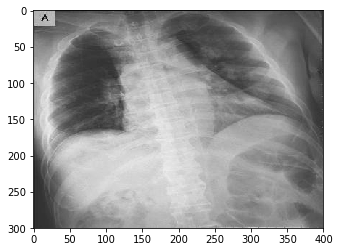

In [49]:
plt.imshow(train_imgs_chest[0], cmap = "gray")

In [50]:
train_imgs_matrix = np.array([train_imgs_chest[i].flatten() for i in range(len(train_imgs_chest))]).T

In [51]:
train_imgs_matrix.shape

(120000, 1010)

In [52]:
avg_x_ray = np.mean(train_imgs_matrix, axis=1)

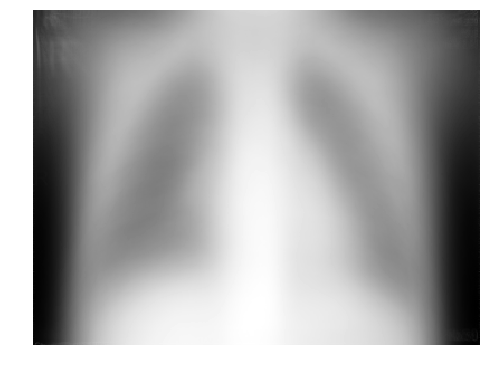

In [53]:
avg_x_ray_img = avg_x_ray.reshape((300, 400))

fig_avg_x_ray = plt.figure(figsize=(8, 8))
plt.imshow(avg_x_ray_img, cmap = "gray")
plt.axis("off")
plt.show()

In [54]:
avg_x_ray_matrix = np.tile(avg_x_ray, (train_imgs_matrix.shape[1], 1)).T
X_chest = train_imgs_matrix - avg_x_ray_matrix
X_chest.shape

(120000, 1010)

Now we compute the U, S and VT matrices after Singular Value Decomposition.

In [55]:
U_x_ray, S_x_ray, VT_x_ray = np.linalg.svd(X_chest, full_matrices=0)

In [56]:
U_x_ray.shape, S_x_ray.shape, VT_x_ray.shape

((120000, 1010), (1010,), (1010, 1010))

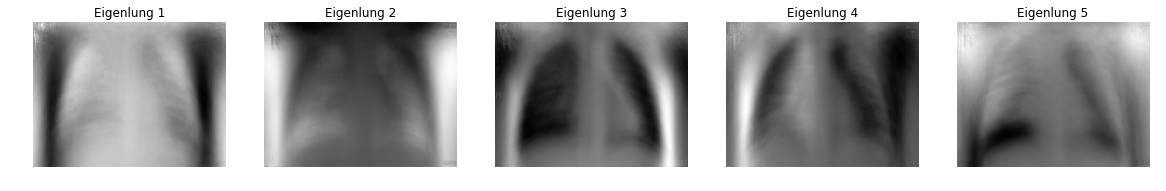

In [105]:
fig_x_ray_eig = plt.figure(figsize = (20, 10))
for i in range(5):
    a = fig_x_ray_eig.add_subplot(1, 5, i+1)
    imgplot = plt.imshow(U_x_ray[:, i].reshape(300, 400), cmap = "gray")
    a.set_title(f'Eigenlung {i+1}')
    plt.axis("off")

In [58]:
train_matrix_covid = np.array([train_imgs_covid[i].flatten() for i in range(len(train_imgs_covid))]).T
train_matrix_bacterial = np.array([train_imgs_bacterial[i].flatten() for i in range(len(train_imgs_bacterial))]).T
train_matrix_viral = np.array([train_imgs_viral[i].flatten() for i in range(len(train_imgs_viral))]).T

In [59]:
train_matrix_covid = train_matrix_covid - np.tile(avg_x_ray, (train_matrix_covid.shape[1], 1)).T
train_matrix_bacterial = train_matrix_bacterial - np.tile(avg_x_ray, (train_matrix_bacterial.shape[1], 1)).T
train_matrix_viral = train_matrix_viral - np.tile(avg_x_ray, (train_matrix_viral.shape[1], 1)).T

In [60]:
train_matrix_covid.shape, train_matrix_bacterial.shape, train_matrix_viral.shape

((120000, 54), (120000, 585), (120000, 371))

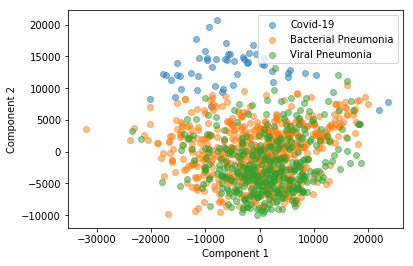

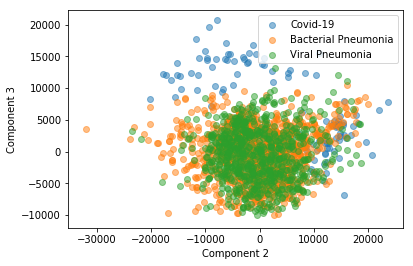

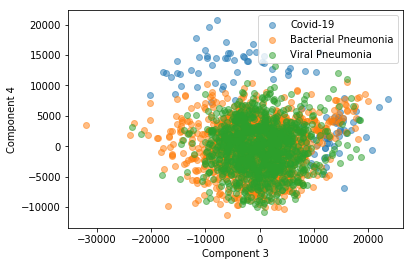

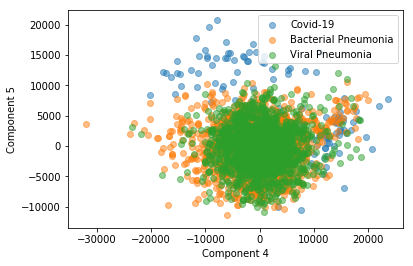

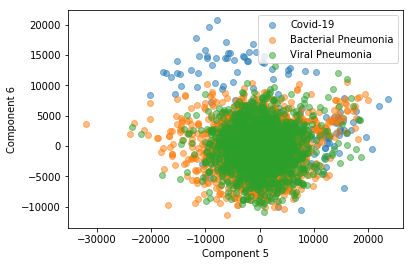

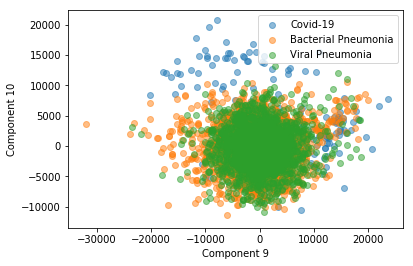

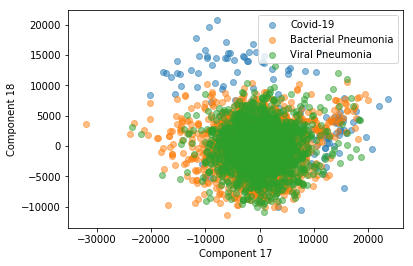

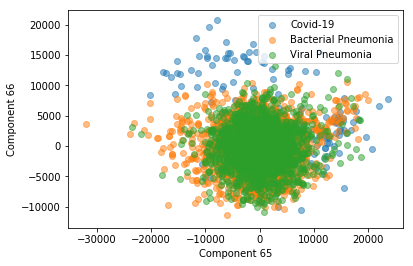

In [65]:
component_1_chest_test = [0, 1, 2, 3, 4, 8, 16, 64]
component_2_chest_test = [1, 2, 3, 4, 5, 9, 17, 65]

x_covid_train = []
y_covid_train = []
x_bacterial_train = []
y_bacterial_train = []
x_viral_train = []
y_viral_train = []

for k in range(len(component_1_chest_test)):
    for i in range(len(train_matrix_covid[1])):
        weights_covid = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+1].T @ train_matrix_covid[:, i]
        x_covid_train.append(weights_covid[0])
        y_covid_train.append(weights_covid[1])
    for i in range(len(train_matrix_bacterial[1])):
        weights_bacterial = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+1].T @ train_matrix_bacterial[:, i]
        x_bacterial_train.append(weights_bacterial[0])
        y_bacterial_train.append(weights_bacterial[1])
    for i in range(len(train_matrix_viral[1])):
        weights_viral = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+1].T @ train_matrix_viral[:, i]
        x_viral_train.append(weights_viral[0])
        y_viral_train.append(weights_viral[1])   
    plt.scatter(x_covid_train, y_covid_train, label='Covid-19', alpha=0.5)
    plt.scatter(x_bacterial_train, y_bacterial_train, label='Bacterial Pneumonia', alpha=0.5)
    plt.scatter(x_viral_train, y_viral_train, label='Viral Pneumonia', alpha=0.5)
    plt.legend()
    plt.xlabel(f'Component {component_1_chest_test[k]+1}')
    plt.ylabel(f'Component {component_2_chest_test[k]+1}')

    plt.show()

From the plots it seems like the separation is the best when plotting the data onto component 1 and component 2. It looks like we cannot distinguish bacterial from viral pneumonia very well, but Covid-19 data seems to separate better. We can try plotting the data in 3D.

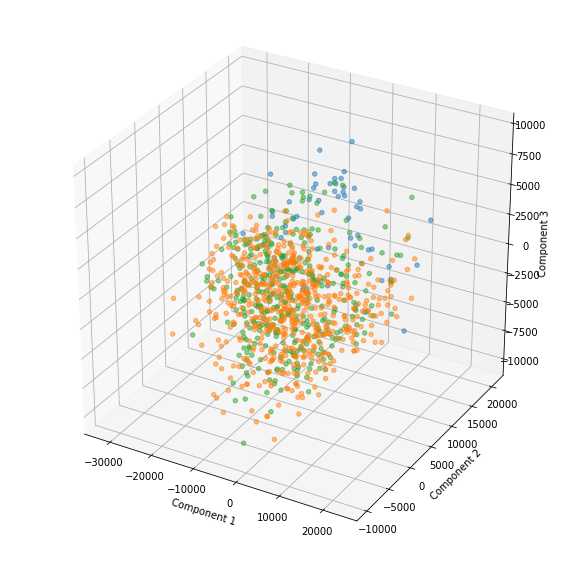

In [75]:
component_1_chest_test = [0, 1, 2, 3, 4, 8, 16, 64]
component_2_chest_test = [1, 2, 3, 4, 5, 9, 17, 65]

x_covid_train_3D = []
y_covid_train_3D = []
z_covid_train_3D = []
x_bacterial_train_3D = []
y_bacterial_train_3D = []
z_bacterial_train_3D = []
x_viral_train_3D = []
y_viral_train_3D = []
z_viral_train_3D = []

fig_x_ray_3D = plt.figure(figsize=(10,10))
for k in range(len(component_1_chest_test)):
    for i in range(len(train_matrix_covid[1])):
        weights_covid = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+2].T @ train_matrix_covid[:, i]
        x_covid_train_3D.append(weights_covid[0])
        y_covid_train_3D.append(weights_covid[1])
        z_covid_train_3D.append(weights_covid[2])
    for i in range(len(train_matrix_bacterial[1])):
        weights_bacterial = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+2].T @ train_matrix_bacterial[:, i]
        x_bacterial_train_3D.append(weights_bacterial[0])
        y_bacterial_train_3D.append(weights_bacterial[1])
        z_bacterial_train_3D.append(weights_bacterial[2])
    for i in range(len(train_matrix_viral[1])):
        weights_viral = U_x_ray[:, component_1_chest_test[k]:component_2_chest_test[k]+2].T @ train_matrix_viral[:, i]
        x_viral_train_3D.append(weights_viral[0])
        y_viral_train_3D.append(weights_viral[1])
        z_viral_train_3D.append(weights_viral[2])
    ax = fig_x_ray_3D.add_subplot(111, projection='3d')
    ax.scatter(x_covid_train_3D, y_covid_train_3D, z_covid_train_3D, alpha=0.5)
    ax.scatter(x_bacterial_train_3D, y_bacterial_train_3D, z_bacterial_train_3D, alpha=0.5)
    ax.scatter(x_viral_train_3D, y_viral_train_3D, z_viral_train_3D, alpha=0.5)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    plt.show()

In [79]:
len(x_covid_train), len(y_covid_train)

(432, 432)

In [84]:
covid_train_data = np.array([x_covid_train, y_covid_train]).T
covid_train_data.shape

(432, 2)

In [88]:
covid_train_labels = [0 for i in range(covid_train_data.shape[0])]
len(covid_train_labels)

432

In [85]:
bacterial_train_data = np.array([x_bacterial_train, y_bacterial_train]).T
bacterial_train_data.shape

(4680, 2)

In [90]:
bacterial_train_labels = [1 for i in range(bacterial_train_data.shape[0])]
len(bacterial_train_labels)

4680

In [91]:
viral_train_data = np.array([x_viral_train, y_viral_train]).T
viral_train_data.shape

(2968, 2)

In [93]:
viral_train_labels = [2 for i in range(viral_train_data.shape[0])]
len(viral_train_labels)

2968

In [94]:
x_ray_train_data = np.concatenate((covid_train_data, bacterial_train_data, viral_train_data), axis=0)
x_ray_train_data.shape

(8080, 2)

In [102]:
x_ray_train_labels = np.concatenate((covid_train_labels, bacterial_train_labels, viral_train_labels), axis=0)
x_ray_train_labels.shape

(6368,)

In [103]:
x_ray_train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [76]:
model_x_ray_svc = svm.SVC(C=1)

In [104]:
#model_x_ray_svc.fit(x_ray_train_data, x_ray_train_labels)

We can train a model using the principal components to predict if a picture belongs to a patient with Covid-19. This is a subject of further research.

### Conclusion

As a conclusion, I can say that the the eigenfaces approach can be used on other types of data than faces for the purpose of classification.

### References

1. Alex P. Pentland, Face recognition using eigenfaces
2. Steven L. Brunton, Data driven science and engineering